In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

df_train["isTrainSet"]= True
df_test["isTrainSet"]= False
df_test["Survived"] = "NA"

df_combined = pd.concat([df_train, df_test], axis=0)

print(df_train.shape)
print(df_train.dtypes)

df_combined.sample(5)


(891, 13)
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
isTrainSet        bool
dtype: object


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,isTrainSet
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.00,0,0,113784,35.5000,T,S,True
836,837,0,3,"Pasic, Mr. Jakob",male,21.00,0,0,315097,8.6625,NaN,S,True
308,1200,NA,1,"Hays, Mr. Charles Melville",male,55.00,1,1,12749,93.5000,B69,S,False
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S,True
848,849,0,2,"Harper, Rev. John",male,28.00,0,1,248727,33.0000,NaN,S,True


In [2]:
# #Fill in Age by Calculate mean age for each Pclass and Sex combination
mean_age_by_pclass_sex = df_combined.groupby(['Pclass', 'Sex'])['Age'].mean()

print(mean_age_by_pclass_sex)

# Function to fill missing age values
def fill_missing_age(row, mean_age_by_pclass_sex):
    if pd.isnull(row['Age']):
        return mean_age_by_pclass_sex.loc[row['Pclass'], row['Sex']]
    else:
        return row['Age']

# Apply the function to the DataFrame
df_combined['Age'] = df_combined.apply(lambda row: fill_missing_age(row, mean_age_by_pclass_sex), axis=1)

# Verify that there are no more missing values in Age
print(df_combined['Age'].isnull().sum())

Pclass  Sex   
1       female    37.037594
        male      41.029272
2       female    27.499223
        male      30.815380
3       female    22.185329
        male      25.962264
Name: Age, dtype: float64
0


In [3]:
# Mapping Age
df_combined.loc[df_combined['Age'] <= 13, 'Age_group'] = 0 # kids
df_combined.loc[(df_combined['Age'] > 13) & (df_combined['Age'] <= 30), 'Age_group'] = 1 # young
df_combined.loc[(df_combined['Age'] > 30) & (df_combined['Age'] <= 45), 'Age_group'] = 2 # mature1
df_combined.loc[(df_combined['Age'] > 45) & (df_combined['Age'] <= 60), 'Age_group'] = 3 # old
df_combined.loc[(df_combined['Age'] > 60) & (df_combined['Age'] <= 100), 'Age_group'] = 4 # very old

In [4]:
#Extract Embarked


# Find the most frequent value in the 'Embarked' column
most_frequent_embarked = df_combined['Embarked'].mode()[0]

# Display the most frequent value for verification
print(f"The most frequent value in the 'Embarked' column is: {most_frequent_embarked}")

# Fill missing values in the 'Embarked' column with the most frequent value
df_combined['Embarked'].fillna(most_frequent_embarked, inplace=True)

# Verify that there are no more missing values in the 'Embarked' column
print(df_combined['Embarked'].isnull().sum())

The most frequent value in the 'Embarked' column is: S
0


In [5]:
med_fare = df_combined.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_combined['Fare'] = df_combined['Fare'].fillna(med_fare)

In [6]:
# Fill missing values in the 'Cabin' column with a placeholder
df_combined['Cabin'].fillna('Unknown', inplace=True)

# Extract the deck information from the 'Cabin' column
df_combined['Deck'] = df_combined['Cabin'].apply(lambda x: x[0] if x != 'Unknown' else 'Unknown')

# Ensure 'Survived' is numeric
df_combined['Survived'] = pd.to_numeric(df_combined['Survived'], errors='coerce')

# Group by Deck and Pclass to count the frequencies
deck_pclass_distribution = df_combined.groupby(['Deck', 'Pclass']).size().unstack(fill_value=0)

# Display the distribution
print(deck_pclass_distribution)

Pclass    1    2    3
Deck                 
A        22    0    0
B        65    0    0
C        94    0    0
D        40    6    0
E        34    4    3
F         0   13    8
G         0    0    5
T         1    0    0
Unknown  67  254  693


In [7]:
# Extract titles from the Name column
df_combined['Title'] = df_combined['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# # Simplify titles
df_combined['Title'] = df_combined['Title'].replace(['Miss', 'Mrs','Ms', 'Countess','Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_combined['Title'] = df_combined['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')


print(df_combined['Title'].value_counts())

Title
Mr                          757
Miss/Mrs/Ms                 465
Master                       61
Dr/Military/Noble/Clergy     26
Name: count, dtype: int64


In [8]:
df_combined['Ticket_Frequency'] = df_combined.groupby('Ticket')['Ticket'].transform('count')

In [9]:
df_combined['Family_Size'] = df_combined['SibSp'] + df_combined['Parch'] + 1

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_combined['Family_Size_Grouped'] = df_combined['Family_Size'].map(family_map)

In [10]:
# fill with the median Fare for the Pclass = 3 and Sex= male.
import numpy as np

Fare_Pclass3_male = df_combined.loc[(df_combined['Pclass'] == 3) & (df_combined['Sex'] == 'male'), 'Fare'].median()
df_combined.loc[df_combined['PassengerId'] == 1044, 'Fare'] = df_combined.loc[(df_combined['Pclass'] == 3) & (df_combined['Sex'] == 'male'), 'Fare'].median()
print("medium Fare for Sex = male and Pclass=3: ", Fare_Pclass3_male)

# Divide Fare in 10 levels
n = 10
df_combined['Fare_level'] = pd.cut(df_combined['Fare'], n, labels=np.arange(1,n+1))
df_combined['Fare_range'] = pd.cut(df_combined['Fare'], n)

medium Fare for Sex = male and Pclass=3:  7.8958


In [11]:

df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   PassengerId          1309 non-null   int64   
 1   Survived             891 non-null    float64 
 2   Pclass               1309 non-null   int64   
 3   Name                 1309 non-null   object  
 4   Sex                  1309 non-null   object  
 5   Age                  1309 non-null   float64 
 6   SibSp                1309 non-null   int64   
 7   Parch                1309 non-null   int64   
 8   Ticket               1309 non-null   object  
 9   Fare                 1309 non-null   float64 
 10  Cabin                1309 non-null   object  
 11  Embarked             1309 non-null   object  
 12  isTrainSet           1309 non-null   bool    
 13  Age_group            1309 non-null   float64 
 14  Deck                 1309 non-null   object  
 15  Title                1309 n

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Filter the dataset to only include the training set
train_data = df_combined[df_combined['isTrainSet'] == True]

# Select the features and the target variable
features = ['Pclass', 'Sex', 'Age', 'Age_group', 'Embarked', 'Title', 'Ticket_Frequency', 'Family_Size_Grouped', 'Fare', 'SibSp', 'Parch']
target = 'Survived'

# Drop unnecessary columns
train_data = train_data[features + [target]]

# One-hot encode categorical features
categorical_features = ['Sex', 'Embarked', 'Title', 'Family_Size_Grouped']
numeric_features = ['Pclass', 'Age', 'Ticket_Frequency', 'Fare', 'Age_group', 'SibSp', 'Parch']

# Preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create and evaluate the model
X = train_data[features]
y = train_data[target]

# Split into training and evaluation sets
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

# ... (keep all the data preparation steps the same) ...

# Define the parameter grid for Grid Search
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__subsample': [0.8, 1.0],
    'classifier__max_features': ['sqrt', 'log2']
}

# Initialize the Gradient Boosting model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', GradientBoostingClassifier(random_state=42))])

# Initialize Grid Search
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit Grid Search to the data
model_grid = grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {model_grid.best_params_}")
print(f"Best training score: {model_grid.best_score_}")

# Evaluate the model on the evaluation set
y_pred = model_grid.predict(X_eval)
print("\nEvaluation metrics:")
print(f"Accuracy: {accuracy_score(y_eval, y_pred):.4f}")
print(f"Precision: {precision_score(y_eval, y_pred):.4f}")
print(f"Recall: {recall_score(y_eval, y_pred):.4f}")
print(f"F1-score: {f1_score(y_eval, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_eval, y_pred))

Best parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 7, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best training score: 0.8347483870967741

Evaluation metrics:
Accuracy: 0.8209
Precision: 0.8539
Recall: 0.6847
F1-score: 0.7600

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.92      0.86       157
         1.0       0.85      0.68      0.76       111

    accuracy                           0.82       268
   macro avg       0.83      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268



In [14]:
# Evaluate on the validation set
best_rf_model = model_grid.best_estimator_
y_pred = best_rf_model.predict(X_eval)

accuracy = accuracy_score(y_eval, y_pred)
print(f"Validation accuracy: {accuracy}")

Validation accuracy: 0.8208955223880597


In [15]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

# Define the scoring
scoring = 'accuracy'

# Perform k-fold cross-validation for Random Forest
rf_cv_results = cross_validate(best_rf_model, X_train, y_train, cv=10, scoring=scoring, return_train_score=True)
print("Random Forest Cross-Validation Results:")
print(f"Train Accuracy Score: {rf_cv_results['train_score'].mean():.2f} (+/- {rf_cv_results['train_score'].std() * 2:.2f})")
print(f"Test Accuracy Score: {rf_cv_results['test_score'].mean():.2f} (+/- {rf_cv_results['test_score'].std() * 2:.2f})")

Random Forest Cross-Validation Results:
Train Accuracy Score: 0.91 (+/- 0.01)
Test Accuracy Score: 0.84 (+/- 0.09)


Length of preprocessed_feature_names: 20
Length of feature_importances: 20
     Pclass     Sex        Age  Age_group Embarked        Title  \
445       1    male   4.000000        0.0        S       Master   
650       3    male  25.962264        1.0        S           Mr   
172       3  female   1.000000        0.0        S  Miss/Mrs/Ms   
450       2    male  36.000000        2.0        S           Mr   
314       2    male  43.000000        2.0        S           Mr   

     Ticket_Frequency Family_Size_Grouped     Fare  SibSp  Parch  
445                 3               Small  81.8583      0      2  
650                 1               Alone   7.8958      0      0  
172                 3               Small  11.1333      1      1  
450                 4               Small  27.7500      1      2  
314                 3               Small  26.2500      1      1  


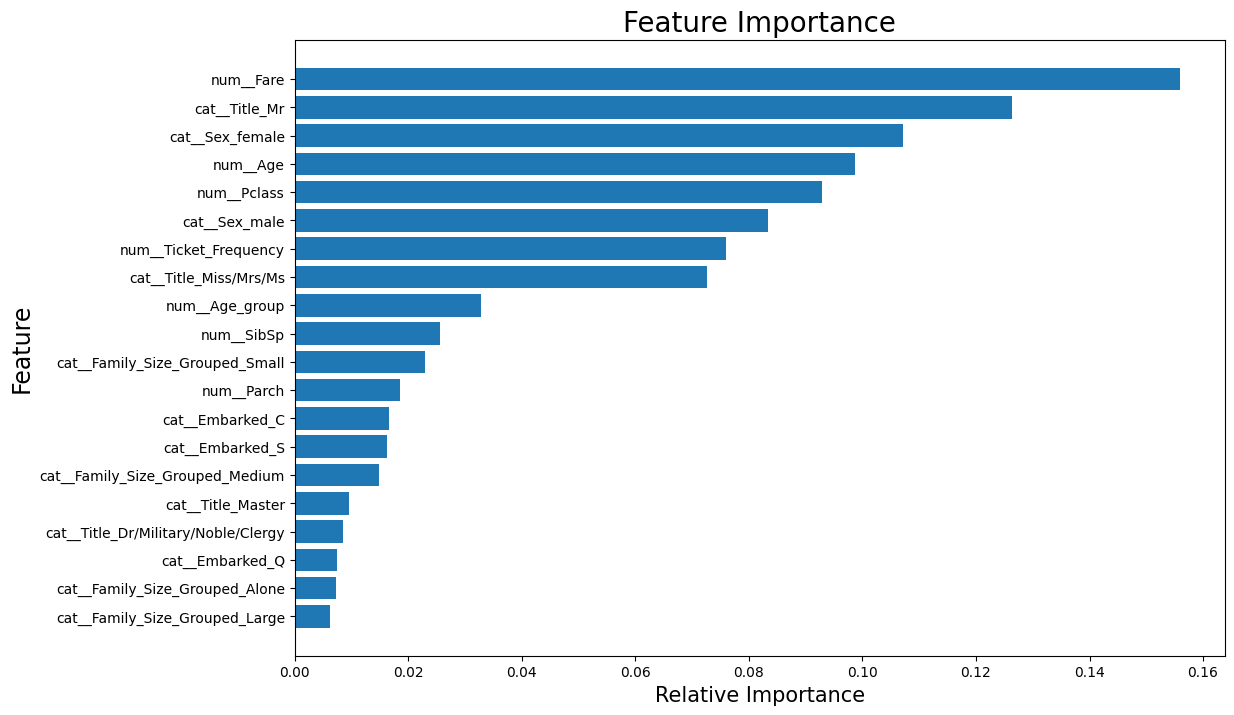

In [16]:
rf_model = best_rf_model.named_steps['classifier']

# Get the feature importances from the RandomForest model
feature_importances = rf_model.feature_importances_

# Get the feature names after preprocessing
preprocessed_feature_names = best_rf_model.named_steps['preprocessor'].get_feature_names_out()



# Print the lengths to verify
print(f"Length of preprocessed_feature_names: {len(preprocessed_feature_names)}")
print(f"Length of feature_importances: {len(feature_importances)}")

# Check the first few rows of the training data
print(X_train.head())

# Return the indices of the sorted importances
indices = np.argsort(feature_importances)

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.barh(range(len(indices)), feature_importances[indices], align='center')

# Label the plot
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Relative Importance', fontsize=15)
plt.ylabel('Feature', fontsize=17)
plt.yticks(range(len(indices)), [preprocessed_feature_names[i] for i in indices])

# Display the plot
plt.show()

In [17]:
# Filter the dataset to only include the test set
test_data = df_combined[df_combined['isTrainSet'] == False]

# Preprocess the test data
X_test = test_data[features]

#Use the trained model to predict the survival status for the test set
y_pred_test = best_rf_model.predict(X_test)

# Convert predictions to integer type
y_pred_test = y_pred_test.astype(int)

# Create a DataFrame with 'PassengerId' and 'Survived' columns
result_df = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': y_pred_test
})

# Display the results
print(result_df.head())

result_df.to_csv('titanic_test_predictions.csv', index=False)

len(result_df)

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1


418

In [18]:
import pandas as pd

# Load the CSV files into DataFrames
df1 = pd.read_csv('titanic_test_predictions.csv')
df2 = pd.read_csv('titanic_test_predictions1.csv')

# Ensure the dataframes are aligned
df1 = df1.sort_values(by='PassengerId').reset_index(drop=True)
df2 = df2.sort_values(by='PassengerId').reset_index(drop=True)

# Check for differences
diff = df1[df1 != df2]

# Drop rows and columns where there are no differences
diff = diff.dropna(how='all').dropna(axis=1, how='all')

# Display the differences
print("Differences between the two DataFrames:")
print(diff)

Differences between the two DataFrames:
     Survived
1         0.0
20        1.0
23        1.0
33        0.0
34        1.0
90        0.0
104       0.0
177       1.0
225       0.0
234       1.0
236       1.0
249       0.0
309       0.0
313       0.0
339       1.0
382       0.0
412       0.0
417       1.0
